In [1]:
import uproot3 as uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def loadSingleFile( tfile, treename, flatenndf=False ):
    ttree = uproot.open(tfile)
    data = ttree[treename].arrays(outputtype=pd.DataFrame,flatten=flatenndf)
    return data

def loadFiles( filelist, treename1, treename2, maxfiles=100, flatenndf=False):
    data1 = pd.DataFrame()
    data2 = pd.DataFrame()
    for i,tfile in enumerate(filelist[0:maxfiles]):
        if i%10 == 0:
            print("{} files processed".format(i))
        ttree = uproot.open(tfile)
        data1 = pd.concat([data1, ttree[treename1].arrays(outputtype=pd.DataFrame,flatten=flatenndf)])
        data2 = pd.concat([data2, ttree[treename2].arrays(outputtype=pd.DataFrame,flatten=flatenndf)])
    return data1, data2

In [2]:
### PREPARE DATA ####
#MATCHES = "../output/run8461_matched_light_tracks.txt"
#LIGHTINFO = "../inputs/run8461_tracks_BNBMAJORITY_files.txt"

MATCHES = "../output/run8413_matched_light_tracks.txt"
LIGHTINFO = "../inputs/run8413_tracks_BNB_files.txt"
FILENAMES = [ line.strip() for line in open(LIGHTINFO, "r") ]

maxim = 1

In [3]:
## Get the light data and combine the two cryostats

#dfw, dfe = loadFiles(FILENAMES, "simpleLightAna/opflashCryoW_flashtree", "simpleLightAna/opflashCryoE_flashtree", maxim)
#dfw["cryo"] = 1
#dfe["cryo"] = 0
#dfw.drop(columns=["multiplicity","multiplicity_right","multiplicity_left","sum_pe","sum_pe_right","sum_pe_left"],inplace=True)
#dfe.drop(columns=["multiplicity","multiplicity_right","multiplicity_left","sum_pe","sum_pe_right","sum_pe_left"],inplace=True)
#df = pd.concat([dfe, dfw])

#del dfw
#del dfe
FILENAME = FILENAMES[0]

### Get optical data
dfw = loadSingleFile(FILENAME, "simpleLightAna/opflashCryoW_flashtree")
dfe = loadSingleFile(FILENAME, "simpleLightAna/opflashCryoE_flashtree")
dfw["cryo"] = 1
dfe["cryo"] = 0
df = pd.concat([dfe, dfw])
df = df.drop(columns=["multiplicity","multiplicity_right","multiplicity_left","sum_pe","sum_pe_right","sum_pe_left"])
del dfw
del dfe

dfopw = loadSingleFile(FILENAME, "simpleLightAna/opflashCryoW_ophittree")
dfope = loadSingleFile(FILENAME, "simpleLightAna/opflashCryoE_ophittree")
dfope["cryo"] = 0
dfopw["cryo"] = 1
dfop = pd.concat([dfope, dfopw])                
del dfopw
del dfope

### Get the geometry
geo = loadSingleFile(FILENAME, "simpleLightAna/geotree")
x = geo.pmt_x.values[0] ; y = geo.pmt_y.values[0] ; z = geo.pmt_z.values[0]
dfop["pmt_x"] = [ x[ch] for ch in dfop.channel_id.values ] 
dfop["pmt_y"] = [ y[ch] for ch in dfop.channel_id.values ] 
dfop["pmt_z"] = [ z[ch] for ch in dfop.channel_id.values ]
geo.to_csv("pmt_positions.csv")
del geo

### Combine together
dfop = dfop.groupby(["run", "event", "cryo","flash_id","channel_id"]).agg({ "start_time":"min", "pmt_y":"mean", "pmt_x":"mean", "pe":"sum", "pmt_z":"mean" }).reset_index()
dfop = dfop.groupby(["run", "event", "cryo","flash_id"]).agg(list)
dfop.rename(columns={'start_time':"time_pmt", "pe":"pe_pmt"}, inplace=True)
df = (df.join( dfop, on=["run", "event", "cryo", "flash_id"], how='inner'))

del dfop

### Now match with the selected tracks
dfmatches = pd.read_csv(MATCHES)
dfmatches.rename(columns={'flashID':"flash_id"}, inplace=True)
dfmatches.set_index(["run", "event", "cryo", "flash_id"], inplace=True)
df = (df.join( dfmatches, on=["run", "event", "cryo", "flash_id"], how='inner'))

print("Consider {} tracks".format( len(df) ) )

Consider 66 tracks


In [4]:
for ev in df.event.to_numpy():
    if ev == 13571:
        print ( "HERE!")
#df.head(100)

HERE!
HERE!


In [5]:
df.head()

,run,event,timestamp,flash_id,flash_time,flash_y,flash_width_y,flash_z,flash_width_z,cryo,...,trackStartX,trackStartY,trackStartZ,trackEndX,trackEndY,trackEndZ,trackDirX,trackDirY,trackDirZ,trackLenght
entry,,,,,,,,,,,,,,,,,,,,,
22,8413,13571,1653364008,1,123.209999,-45.391109,69.582420,458.147430,144.994003,0,...,-159.097,133.570,646.136,-359.359,-181.822,322.25000,-0.264891,-0.778620,-0.568844,494.448
23,8413,13571,1653364008,2,-367.380005,-10.048380,74.585442,-742.807922,89.525337,0,...,-297.897,130.758,-768.340,-131.542,-180.191,-775.33700,0.259006,-0.965847,-0.007507,352.721
62,8413,13727,1653364239,4,-182.692001,-33.549179,71.202042,-78.356415,139.667908,0,...,-142.723,133.774,-144.376,-224.185,-177.923,-9.87648,-0.167863,-0.905022,0.390842,349.115
68,8413,13735,1653364248,1,-880.081970,-24.714928,76.095276,-514.642273,170.319321,0,...,-148.350,131.447,-733.058,-219.173,-178.034,-328.40700,-0.084684,-0.402259,0.911601,514.331
72,8413,13735,1653364248,5,-510.802002,-21.858324,72.823303,599.350891,122.030098,0,...,-252.705,131.201,574.443,-184.407,-179.431,624.60200,-0.058746,-0.988092,0.142211,321.982


In [6]:
## Explode the dataframe 
df = df.explode(["time_pmt", "pmt_x", "pmt_y", "pe_pmt", "pmt_z", "channel_id"])

## Import and use laser correction
## WARNING: DO NOT USE IF CORRECTIONS WERE ALREADY APPLIED AT STAGE0 
## note: laser corrections are in ns!

LASERCORR="../inputs/laser_time_corrections_20220408.csv"
#LASERCORR="../inputs/laser_time_corrections_9305.csv"
lasercorr = pd.read_csv(LASERCORR).set_index(["channel_id"])
lasercorr['t_signal'] = lasercorr['t_signal']/1e3  #convert ns to us

df = df.join( lasercorr[["t_signal"]], on=["channel_id"])
df['time_pmt'] = df['time_pmt'] - df['t_signal']  #WARNING: CURRENTLY REMOVING LASER CORRECTIONS!

In [7]:
def _seltpc(xx):
    if xx < -200:
        return 0
    elif xx < -20 and xx > -200:
        return 1
    elif xx > 20 and xx < 200:
        return 2
    elif xx > 200:
        return 3

RUN=8413
EVENT=13571
CRYO=0
FLASH=2
PECUT = 100

ch=10
chx, chy, chz = -371.0702,-76.25,-673.3805

# Keep only the reference event
df["tpc"] = [ _seltpc(val) for val in df.pmt_x.values ]
evtdf = df[(df.event==EVENT) & (df.cryo==CRYO) & (df.flash_id==FLASH)]

zpos = [ z[ch] for ch in range(0,90)]
ypos = [ y[ch] for ch in range(0,90)]

len(evtdf)

76

EMPTY WE
EMPTY WW


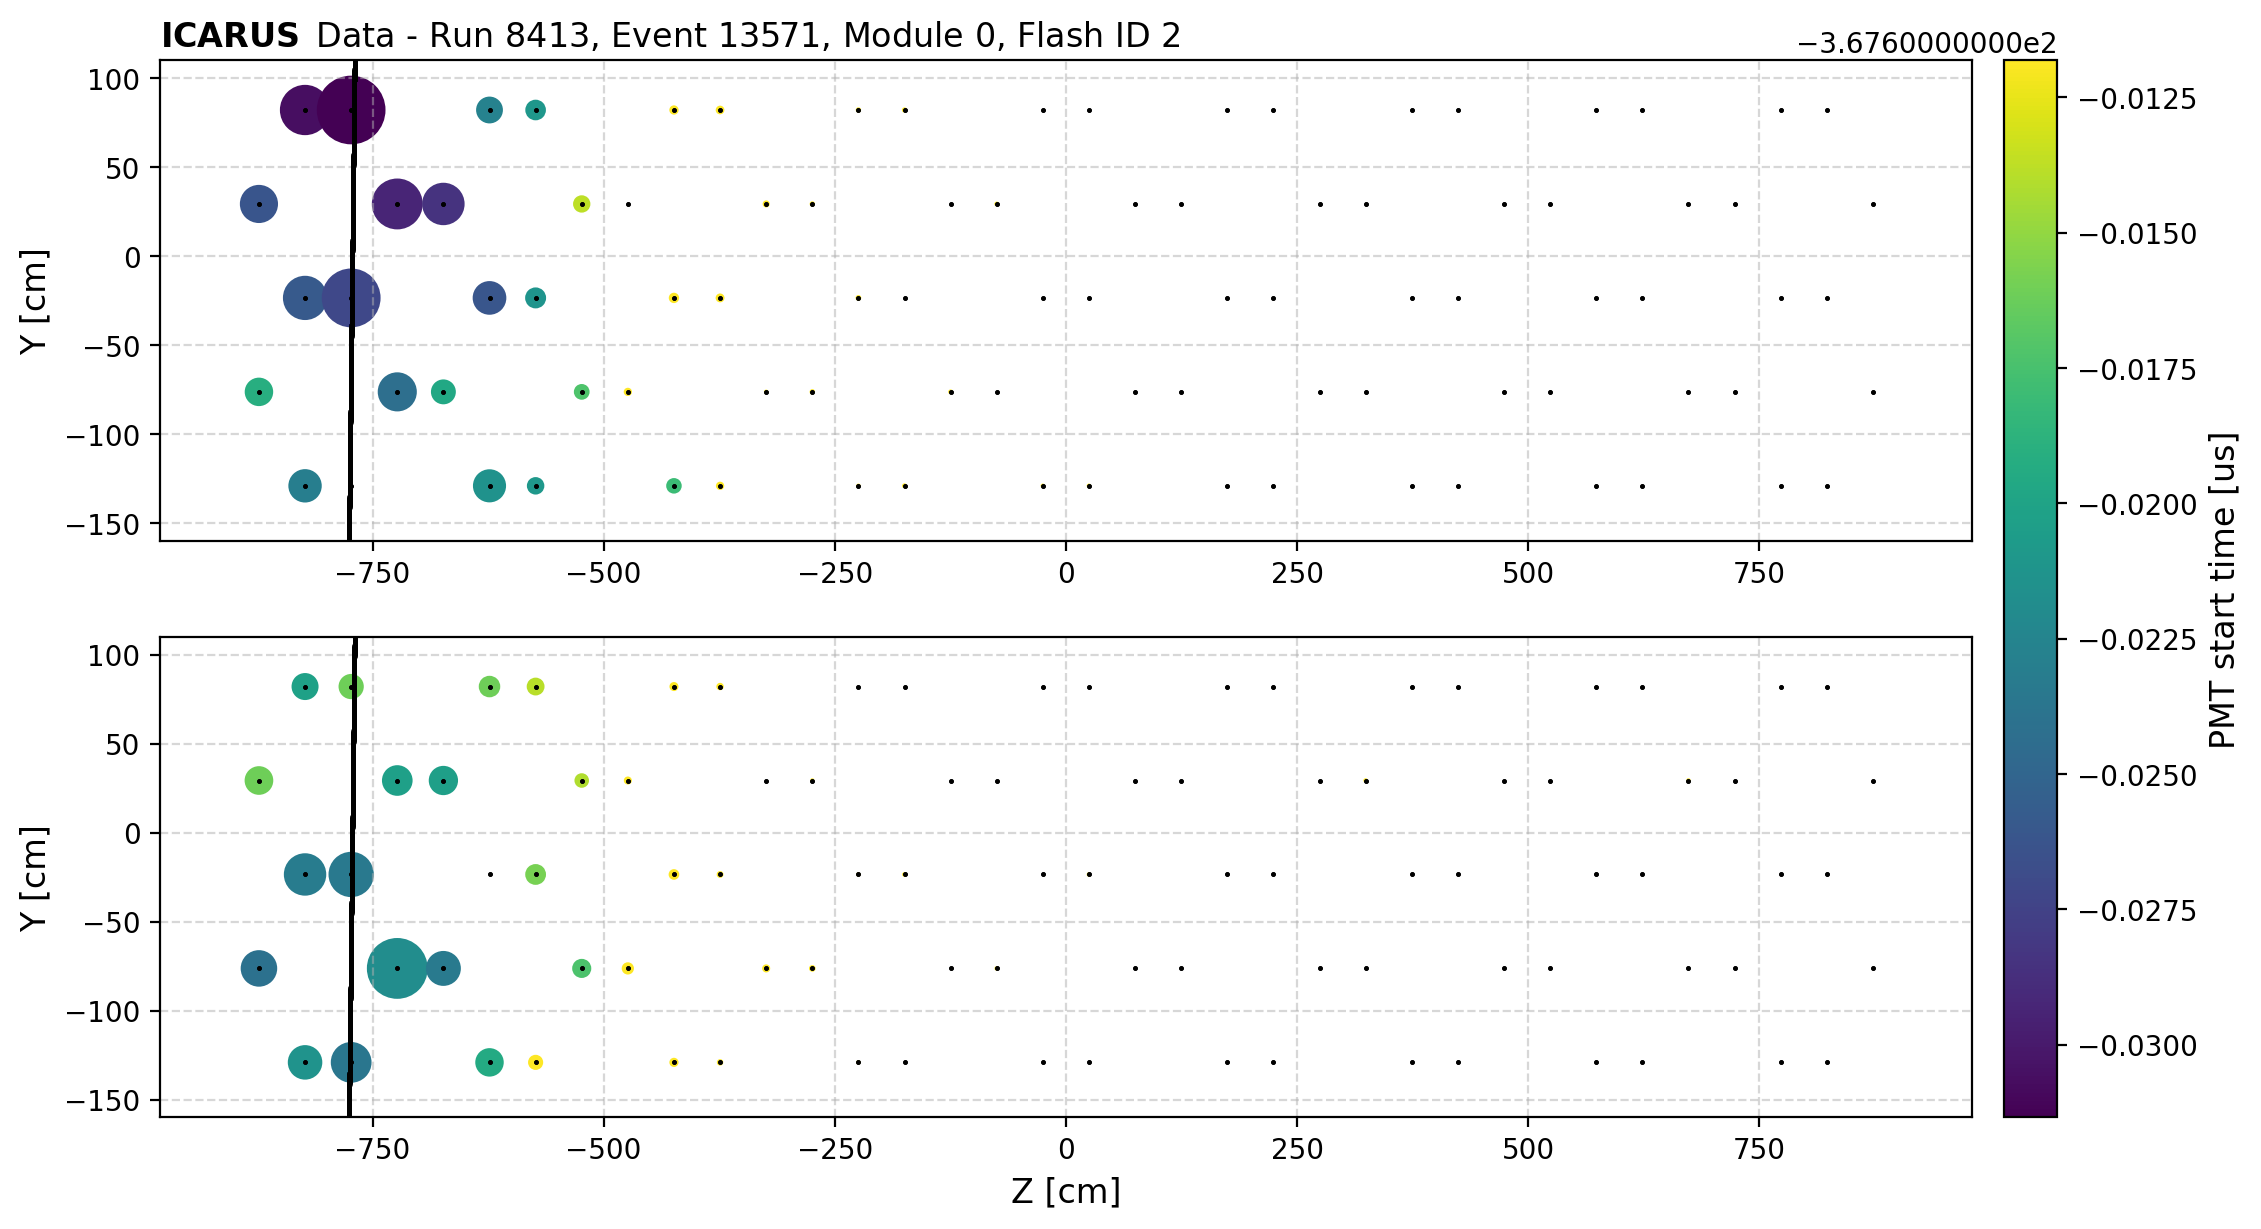

In [19]:
# Here we make the plots 
fig, ax = plt.subplots( 2,1, figsize=(14, 7), dpi=200 )

tmin = evtdf[evtdf.pe_pmt>50]["time_pmt"].min()
tmax = evtdf[evtdf.pe_pmt>50]["time_pmt"].max()

for i, name in enumerate(["EE", "EW", "WE", "WW"]):
    
    _stpc=evtdf.tpc==i
    tpc = evtdf[_stpc]
    
    if(len(tpc) ==0 ):
        print("EMPTY " + name )
        continue
    
    _sel = tpc["pe_pmt"] > 0
        
    sizes = pd.to_numeric(tpc[_sel].pe_pmt, errors='coerce')
    
    out1 = ax[i].scatter( x = tpc[_sel].pmt_z, y = tpc[_sel].pmt_y, s=sizes*0.35, c= tpc[_sel].time_pmt, cmap='viridis',
                          vmin=tmin, vmax=tmax)
    #fig.colorbar( out1, ax=ax[i], label="Pulse start time [us]", pad=0.01 )
    #ax[i].scatter(x=tpc.pmt_z,y=tpc.pmt_y,s=0.5,c="black",marker="o")
    ax[i].scatter(x=zpos,y=ypos,s=0.5,c="black",marker="o")

    #if(name=="EE"):
    #    ax[i].scatter(x=chz,y=chy,color="magenta",marker="x")
    ax[i].plot( [evtdf.trackStartZ, evtdf.trackEndZ], [evtdf.trackStartY, evtdf.trackEndY], color='black' )
    #plt.savefig("../figs/run9337_ch{}_event2d_{}_cryo_{}_flash_{}.png".format(ch,EVENT,CRYO,FLASH),dpi=100)
    
for i in range(2):
    ax[i].set_ylabel("Y [cm]", fontsize=12)
    if i!=0:
        ax[i].set_xlabel("Z [cm]", fontsize=12)
    ax[i].set_xlim( (-980, 980) )
    ax[i].set_ylim( (-160, 110) )
    ax[i].grid(alpha=0.5, linestyle="dashed") 
    
cbar = fig.colorbar(out1, ax=ax, orientation='vertical', pad=0.015)
cbar.set_label(label="PMT start time [us]", size=12)

watermark = r'$\mathbf{ICARUS}\,$ Data' +' - Run {}, Event {}, Module {}, Flash ID {}'.format(
            RUN, EVENT, CRYO, FLASH)
ax[0].text(0.0, 1.05, watermark, fontsize=12, color='black', alpha=1,
         ha='left', va='center', transform=ax[0].transAxes)

#plt.tight_layout()
plt.savefig("../figs/run{}_event{}_event2d_cryo{}_flash{}.pdf".format(RUN,EVENT,CRYO,FLASH),dpi=200)
plt.show()

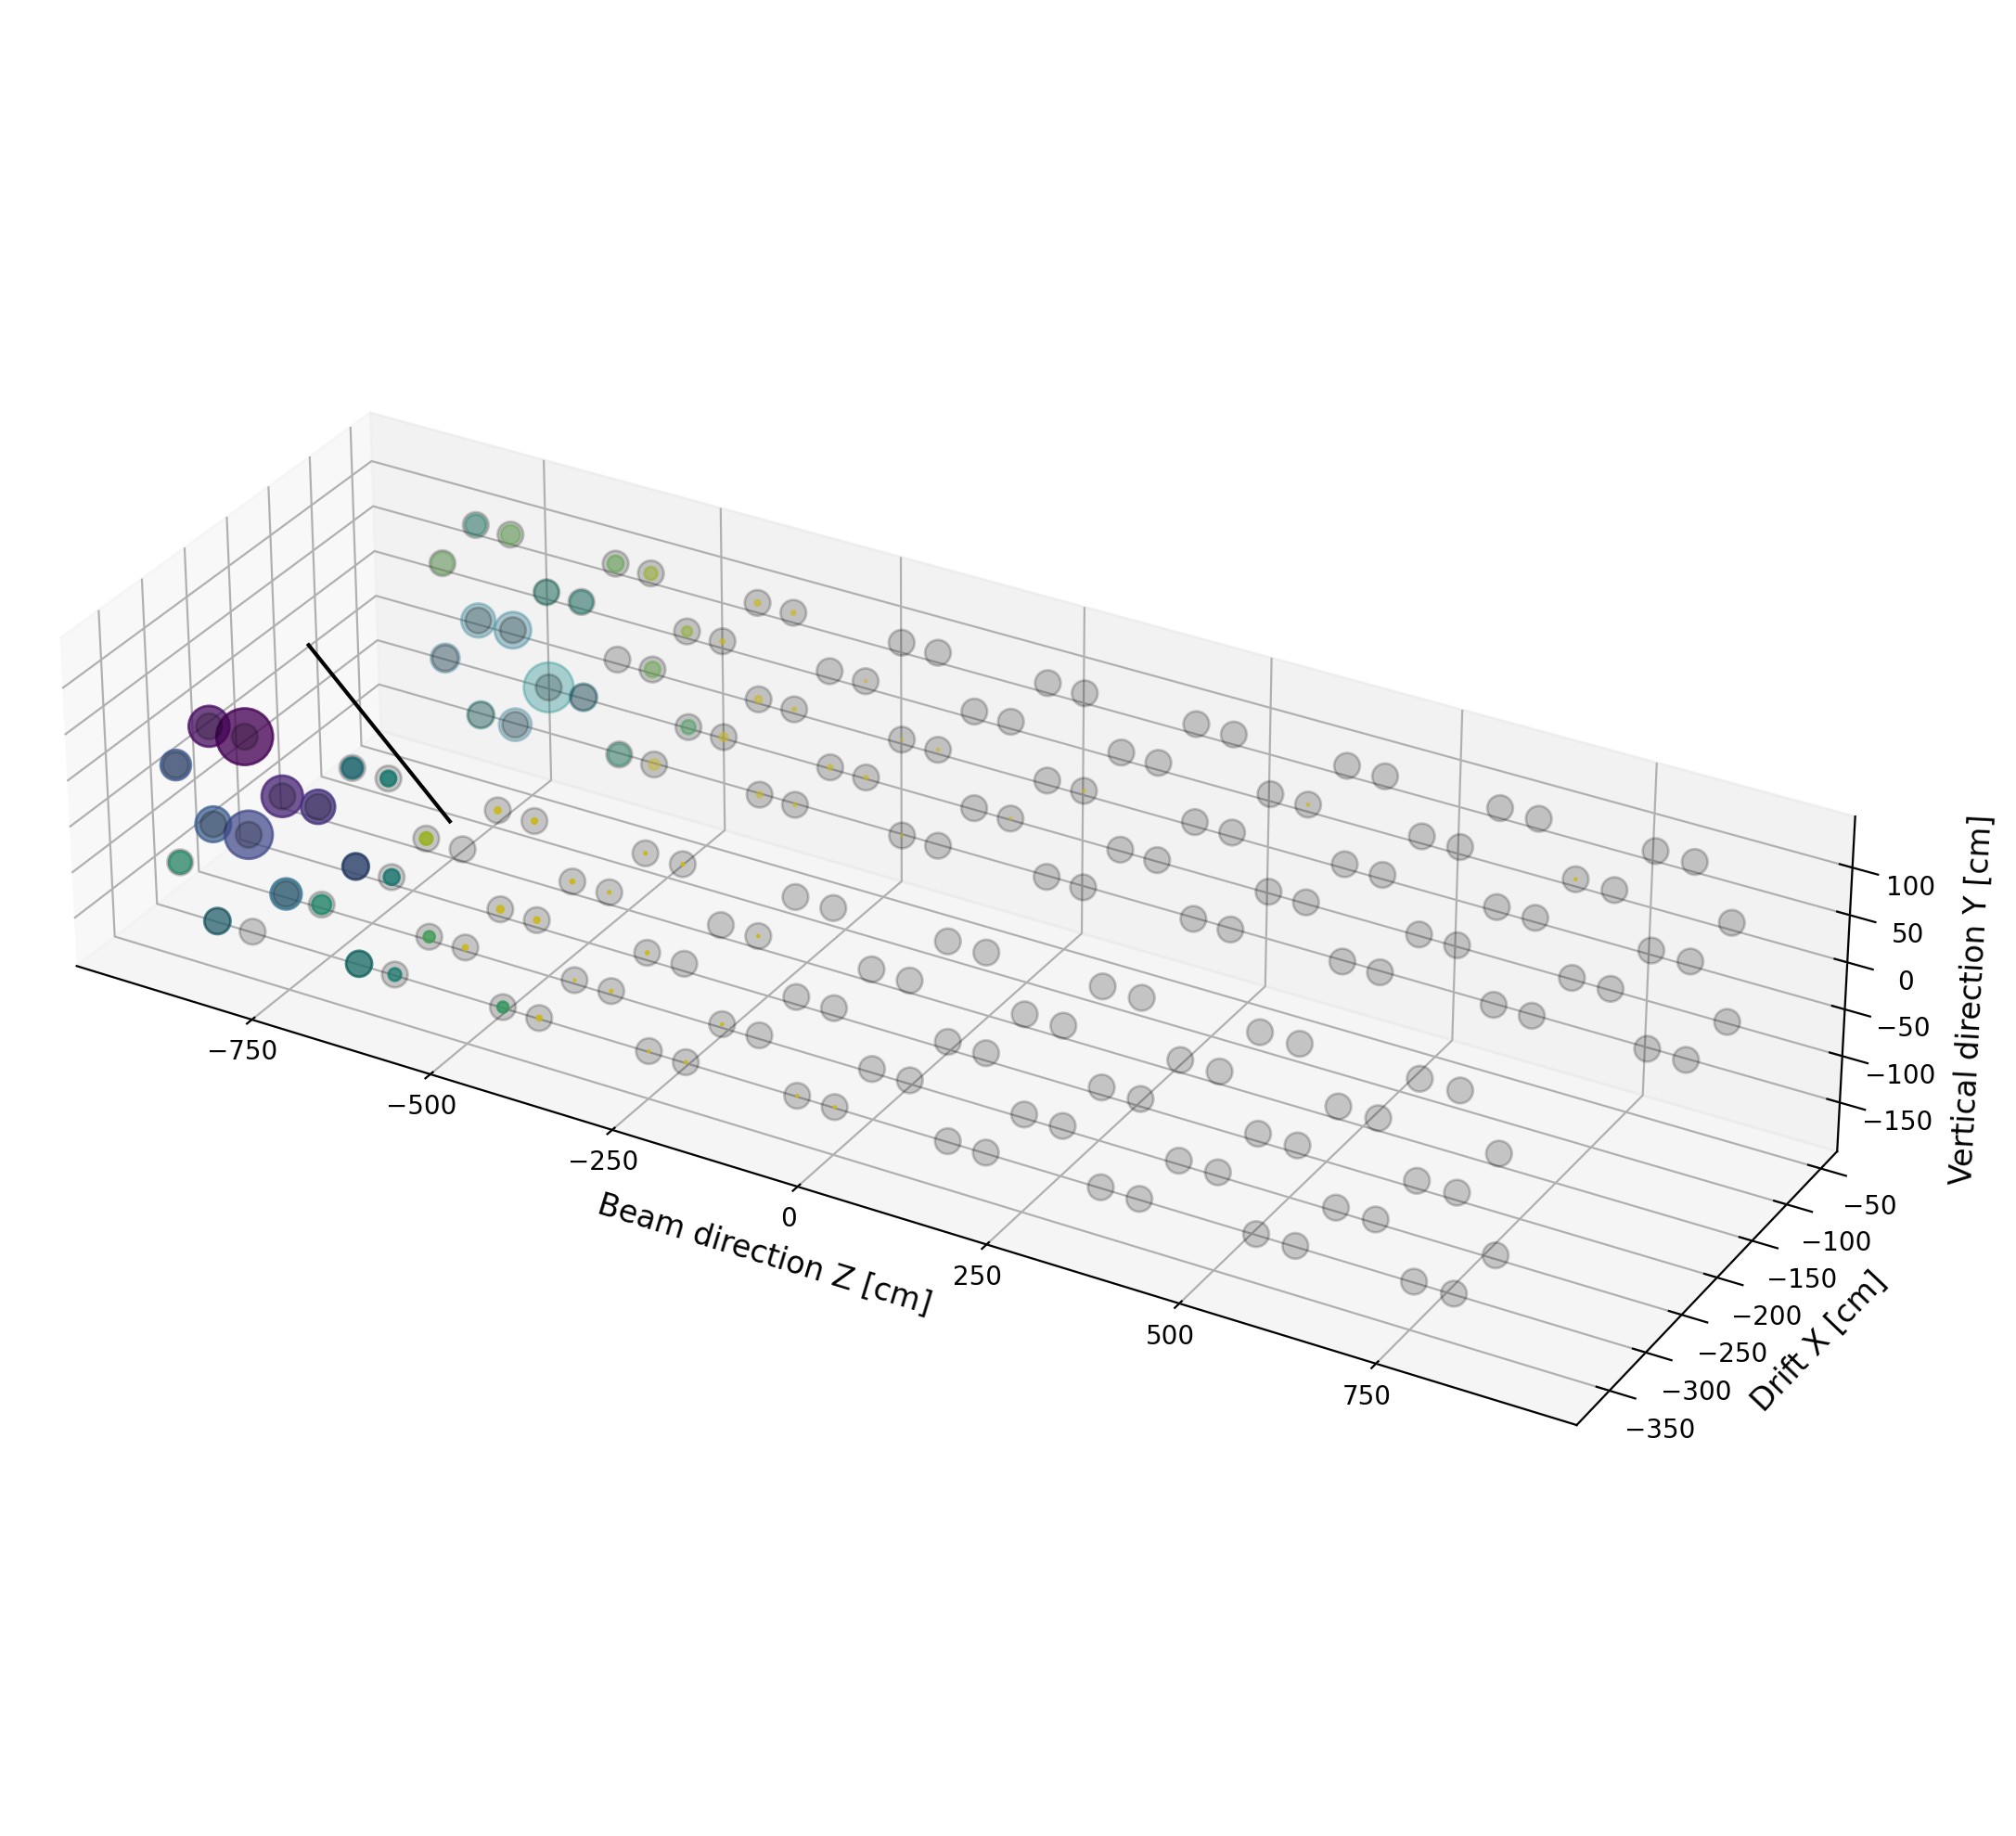

In [12]:
# PLOT in 3D 
fig = plt.figure(figsize=(18, 10), dpi=200)
ax = fig.add_subplot(projection='3d')

zpos = [ z[ch] for ch in range(0,180)]
ypos = [ y[ch] for ch in range(0,180)]
xpos = [ x[ch] for ch in range(0,180)]

_selcryo=evtdf.cryo==CRYO
allcryo = evtdf[_selcryo]

_sel = allcryo.pe_pmt > 0
sizes = pd.to_numeric(allcryo[_sel].pe_pmt, errors='coerce')

_selpmt = allcryo.pmt_x>0
if CRYO == 0:
    _selpmt = allcryo.pmt_x<0

ax.scatter( zpos, xpos, ypos, c='black', s=100, alpha=0.2  )
out1 = ax.scatter( allcryo[_sel].pmt_z, allcryo[_sel].pmt_x , allcryo[_sel].pmt_y, s=sizes*0.3, c=allcryo[_sel].time_pmt, cmap='viridis', vmin=tmin, vmax=tmax ) #YlOrRd
    
ax.plot( [evtdf.trackStartZ.values[0], evtdf.trackEndZ.values[0]], [evtdf.trackStartX.values[0], evtdf.trackEndX.values[0]], [evtdf.trackStartY.values[0], evtdf.trackEndY.values[0]], color='black' )

#ax.scatter(chz,chx,chy,color="magenta",marker="x")

ax.set_box_aspect(aspect = (9, 3, 2))

ax.set_ylabel("Drift X [cm]", fontsize=12)
ax.set_xlabel("Beam direction Z [cm]",fontsize=12, labelpad=20)
ax.set_zlabel("Vertical direction Y [cm]", fontsize=12)
    
fig.tight_layout()
plt.savefig("../figs/run{}_event{}_event3d_cryo{}_flash{}.pdf".format(RUN,EVENT,CRYO,FLASH),dpi=200)
plt.show()

In [11]:
#_pecut=300

#_sel = (evtdf.pe_pmt > _pecut) & (evtdf.channel_id == ch)
#chevtmdf = evtdf[_sel][["channel_id","time_pmt","pe_pmt"]]
#chtime = chevtmdf.time_pmt.values[0]
#chevtmdf.head()

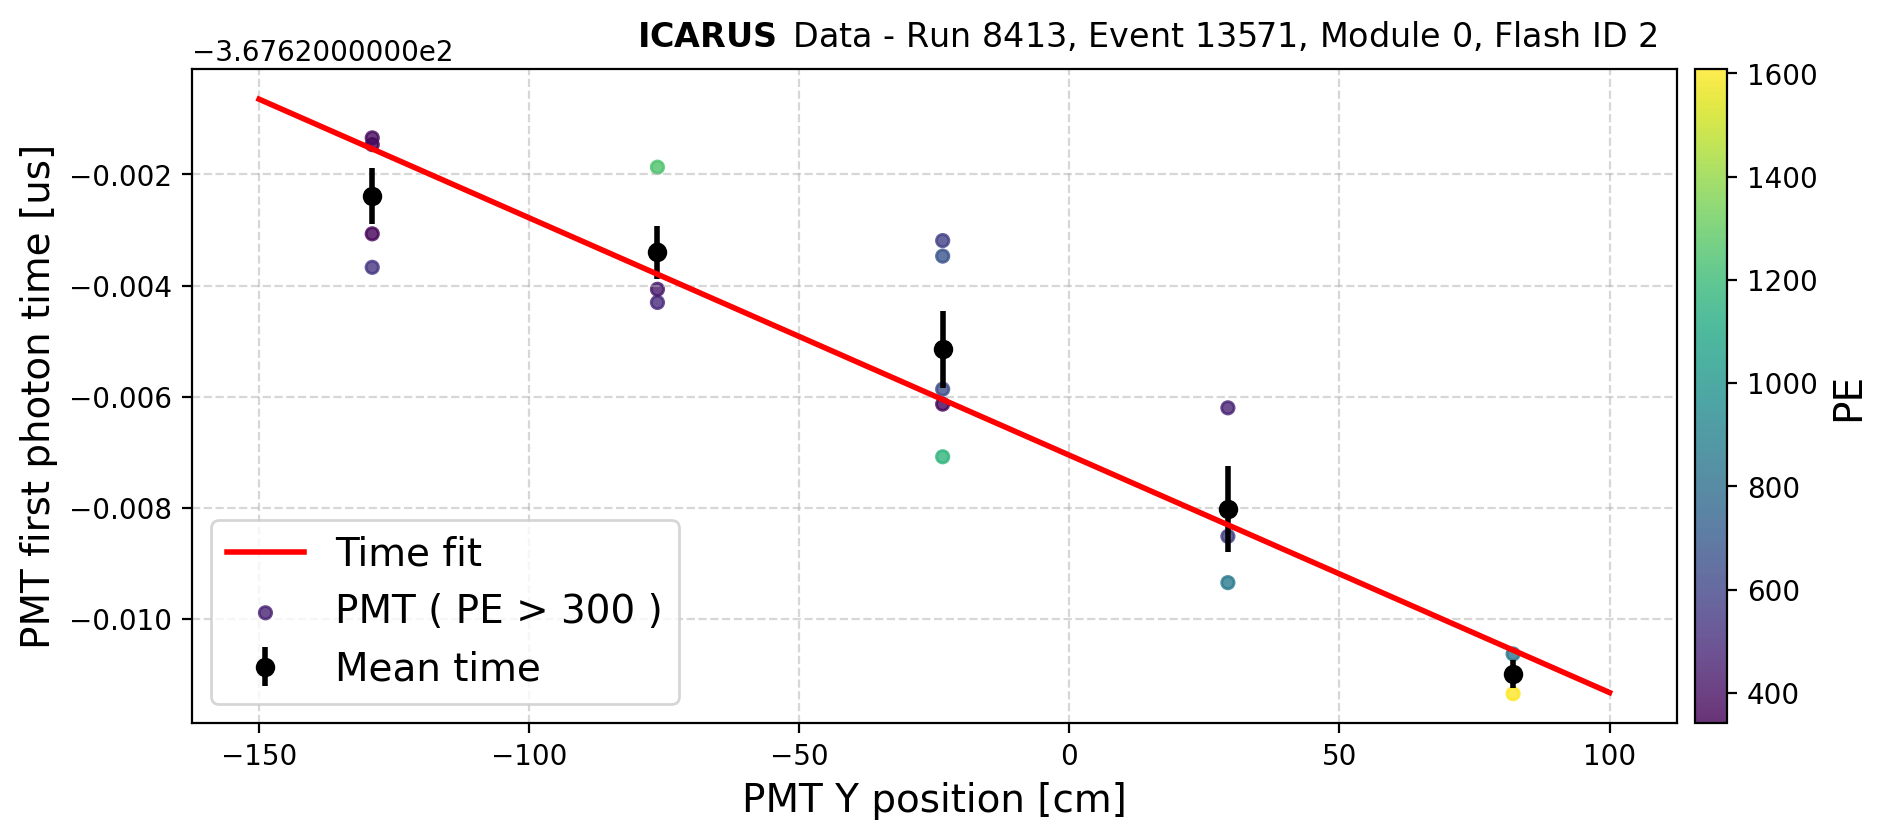

In [16]:
_pecut=300

_sel = evtdf.pe_pmt > _pecut
evtmdf = evtdf[_sel][["time_pmt", "pe_pmt", "pmt_y"]].groupby("pmt_y").apply( 
    lambda x : pd.Series( {
        "mean_time" : np.mean(x.time_pmt),
        "weight_mean_time" : np.average(x.time_pmt, weights=x.pe_pmt), 
        "error_mean_time": np.std(x.time_pmt) / np.sqrt(len(x.time_pmt))
    }) ).reset_index()

fig, ax = plt.subplots( 1,1, figsize=(10, 4.3), dpi=200)

out = ax.scatter( evtdf[_sel].pmt_y, evtdf[_sel].time_pmt, c=evtdf[_sel].pe_pmt, s=20, label='PMT ( PE > {} )'.format(_pecut), cmap='viridis', alpha=0.8 ) #jet
cbar = fig.colorbar( out, ax=ax, pad=0.01 )
cbar.set_label(label="PE", size=14)

#ax.errorbar( x=evtmdf.pmt_y, y=evtmdf.weight_mean_time, yerr=evtmdf.error_mean_time, marker='o', elinewidth=2.0, lw=0, label='Weighted mean time', color='grey' )
ax.errorbar( x=evtmdf.pmt_y, y=evtmdf.mean_time, yerr=evtmdf.error_mean_time, marker='o', elinewidth=2.0, lw=0, label='Mean time', color='black' )

res = stats.linregress( evtmdf.pmt_y, evtmdf.weight_mean_time ) 
ax.plot( np.linspace(-150, 100),  np.linspace(-150, 100)*res.slope+res.intercept, lw=2.0, color='red', label='Time fit' )

#ax.scatter(chy,chtime,color="magenta",marker="x")
#plt.ylim(-367.64,-367.62)

ax.set_ylabel("PMT first photon time [us]", fontsize=14)
ax.set_xlabel("PMT Y position [cm]", fontsize=14)
ax.grid(alpha=0.5, linestyle='dashed')
ax.legend()
ax.legend(loc='lower left',fontsize=14)

watermark = r'$\mathbf{ICARUS}\,$ Data' +' - Run {}, Event {}, Module {}, Flash ID {}'.format(
            RUN, EVENT, CRYO, FLASH)
ax.text(0.30, 1.05, watermark, fontsize=12, color='black', alpha=1,
         ha='left', va='center', transform=ax.transAxes)

fig.tight_layout()
plt.savefig("../figs/run{}_event{}_residuals_cryo{}_flash{}.pdf".format(RUN,EVENT,CRYO,FLASH),dpi=200)
plt.show()

In [13]:
evtmdf.head()

,pmt_y,mean_time,weight_mean_time,error_mean_time
0,-129.050003,-367.622386,-367.622524,0.000504
1,-76.250000,-367.623399,-367.622926,0.000475
2,-23.450001,-367.625147,-367.625380,0.000689
3,29.350000,-367.628019,-367.628324,0.000768
4,82.150002,-367.630985,-367.631098,0.000253


In [14]:
print(evtdf[_sel].pmt_y.to_numpy(), evtdf[_sel].time_pmt.to_numpy())

[29.350000381469727 -129.0500030517578 -23.450000762939453
 82.1500015258789 -23.450000762939453 82.1500015258789 -76.25
 29.350000381469727 29.350000381469727 -129.0500030517578
 -23.450000762939453 -76.25 -129.0500030517578 -23.450000762939453
 -129.0500030517578 -23.450000762939453 -76.25 -76.25] [-367.6261994536562 -367.62306880607815 -367.62586283365624
 -367.63062781039065 -367.6270798263906 -367.6313431878125
 -367.62430348965626 -367.62934474039065 -367.6285114423906
 -367.6214629359219 -367.6261328530781 -367.6240664810781
 -367.62134205492185 -367.6231900499219 -367.6236712300781
 -367.6234698009219 -367.6218692539219 -367.6233578989219]
